In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

In [5]:
# 定义LeNet模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#声明 MNIST 测试数据集何数据加载
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# 定义我们正在使用的设备
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 初始化网络
model = Net().to(device)

# 加载已经预训练的模型
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 在评估模式下设置模型。在这种情况下，这适用于Dropout图层
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [6]:
# FGSM算法攻击代码
def fgsm_attack(image, epsilon, data_grad):
    # 收集数据梯度的元素符号
    sign_data_grad = data_grad.sign()
    # 通过调整输入图像的每个像素来创建扰动图像
    perturbed_image = image + epsilon*sign_data_grad
    # 添加剪切以维持[0,1]范围
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回被扰动的图像
    return perturbed_image


In [7]:
def test( model, device, test_loader, epsilon ):

    # 精度计数器
    correct = 0
    adv_examples = []

    # 循环遍历测试集中的所有示例
    for data, target in test_loader:

        # 把数据和标签发送到设备
        data, target = data.to(device), target.to(device)

        # 设置张量的requires_grad属性，这对于攻击很关键
        data.requires_grad = True

        # 通过模型前向传递数据
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # 如果初始预测是错误的，不打断攻击，继续
        if init_pred.item() != target.item():
            continue

        # 计算损失
        loss = F.nll_loss(output, target)

        # 将所有现有的渐变归零
        model.zero_grad()

        # 计算后向传递模型的梯度
        loss.backward()

        # 收集datagrad
        data_grad = data.grad.data

        # 唤醒FGSM进行攻击
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 重新分类受扰乱的图像
        output = model(perturbed_data)

        # 检查是否成功
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # 保存0 epsilon示例的特例
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 稍后保存一些用于可视化的示例
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 计算这个epsilon的最终准确度
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 返回准确性和对抗性示例
    return final_acc, adv_examples

In [8]:
accuracies = []
examples = []

# 对每个epsilon运行测试
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


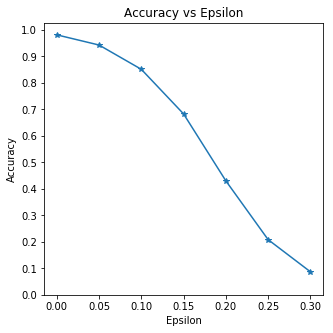

In [9]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

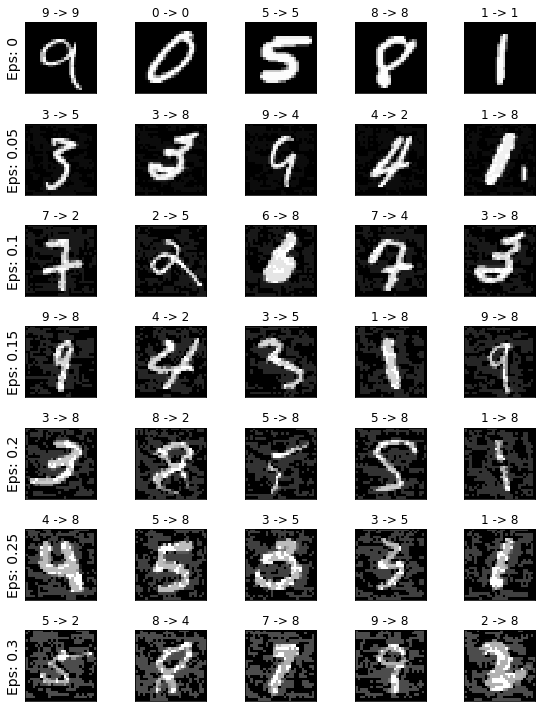

In [10]:
# 在每个epsilon上绘制几个对抗样本的例子
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()